In [1]:
import requests
import json
from PIL import Image
from io import BytesIO
import base64
import numpy as np 
import cupy as cp
import sys
from cuvs.neighbors import hnsw,cagra
import os
import time
sys.path.append('/hpc2hdd/home/ysi538/retrieval')
from MDI_RAG_Image2Image_Research.src.utils.encoder import WSI_Image_UNI_Encoder

from utils import *

/hpc2hdd/home/ysi538/miniconda3/envs/yhre-new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

def load_index_file(index_file):
    index = hnsw.load(hnsw.IndexParams(),index_file, 1024, np.float32, "sqeuclidean")
    return index

def load_info_file(info_file):
    with open (info_file, 'r') as f:
        infos = json.load(f)
    return infos



def search(index, encoder, infos_list, query_path,split_img_fun, top_k=50):
    total_neighbors = []
    total_distances = []
    query_image = request_image(query_path)
    #  
    img_other_info = None
    split_imgs = split_img_fun(query_image, img_other_info)
    #   np.array  
    split_embeddings = np.array([np.array(encoder.encode_image(after_split_img)).astype('float32') for after_split_img in split_imgs])
    
    #   query_embedding  
    if split_embeddings.ndim == 1:
        split_embeddings = split_embeddings.reshape(1, -1)
    
    # print("split_embeddings:", split_embeddings)
    # return split_embeddings
    result_infos = []
    
    time_cost = 0
    begin_time = time.time()
    distances, neighbors = hnsw.search(hnsw.SearchParams(), index, split_embeddings, top_k)
    # distances, neighbors = cagra.search(cagra.SearchParams(),index, split_embeddings, top_k)
    end_time = time.time()
    time_cost += end_time - begin_time
   
    
    neighbors = cp.asarray(neighbors).flatten().tolist()
    distances = cp.asarray(distances).flatten().tolist()
    for neighbor in neighbors:
        result_infos.append(infos_list[neighbor])
    total_neighbors.extend(neighbors)
    total_distances.extend(distances)

    total_distances, total_neighbors, result_infos = zip(*sorted(zip(total_distances, total_neighbors, result_infos)))
    return total_distances[:], total_neighbors[:], result_infos[:], time_cost






In [3]:

image_encoder = WSI_Image_UNI_Encoder()

ssd_dir = "/hpc2ssd/JH_DATA/spooler/ysi538/"

hnsw_index = load_index_file(ssd_dir + "cupy_index_batch_0.bin")
infos_list = load_info_file(ssd_dir + "cupy_infos_batch_0.json")



cuda


In [ ]:
def get_combined_regions_cpu(result_infos):

    search_info_list = []
    
    for info in result_infos:
        search_info = {}
        level = info.split("_")[-1].split(".")[0]
        w = info.split("_")[-3]
        h = info.split("_")[-2]
        x = info.split("_")[-5]
        y = info.split("_")[-4]
        id = info.split("_")[0]
        name = "_".join(info.split("_")[1:-5])
        search_info = {"id": id, "name": name, "x": x, "y": y, "w": w, "h": h, "level": level}
        search_info_list.append(search_info)

    def dfs(node, component, visited):
        
        visited[node] = True
        
        component.append(search_info_list[node])
        
        
        for neighbor in range(len(search_info_list)):
            if not visited[neighbor] and judge_if_connected(search_info_list[node], search_info_list[neighbor]):
                
                dfs(neighbor, component, visited)

    
    visited = [False] * len(search_info_list)
    components = []

    
    begin_time = time.time()
    for i in range(len(search_info_list)):
        if not visited[i]:
            
            current_component = []
            
            dfs(i, current_component, visited)
            
            components.append(current_component)

    
    components = [component for component in components if len(component) > 1]
    end_time = time.time()
    

    return components, end_time - begin_time

In [31]:

query_img_path = " metaservice/api/region/openslide/241183-21.tiff/6400/25344/2240/2240/1"
search_begin_time = time.time()
total_distances, total_neighbors, result_infos, pure_time_cost = search(hnsw_index, image_encoder, infos_list, query_img_path,split_img_fun, 64)
search_end_time = time.time()
search_time_cost = search_end_time - search_begin_time

combine_begin_time = time.time()
combined_regions, pure_combined_time = get_combined_regions_cpu(result_infos)
combine_end_time = time.time()
combine_time_cost = combine_end_time - combine_begin_time

print("search_total_time_cost:", search_time_cost)
print("combine_time_cost:", combine_time_cost)
print("pure search time cost:", pure_time_cost)
print("get_combined_regions_cpu time cost:", pure_combined_time)
len(combined_regions)

/hpc2hdd/home/ysi538/miniconda3/envs/yhre-new/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mdi.hkust-gz.edu.cn'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


search_total_time_cost: 33.63488817214966
combine_time_cost: 12.889387130737305
pure search time cost: 0.23338723182678223
get_combined_regions_cpu time cost: 12.813064336776733


285

In [32]:
pure_combined_time + pure_time_cost

13.046451568603516

In [20]:
url_list = get_url_list_cpu(combined_regions)
embeddings_list = get_result_embeddings(url_list[:], image_encoder)
query_embedding = image_encoder.encode_image(request_image(query_img_path).resize((224, 224)))
score_list = []
for embedding in embeddings_list:
    score = np.dot(query_embedding, embedding) / (np.linalg.norm(query_embedding) * np.linalg.norm(embedding))
    score_list.append(score)
score_list


/hpc2hdd/home/ysi538/miniconda3/envs/yhre-new/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mdi.hkust-gz.edu.cn'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/hpc2hdd/home/ysi538/miniconda3/envs/yhre-new/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mdi.hkust-gz.edu.cn'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/hpc2hdd/home/ysi538/miniconda3/envs/yhre-new/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mdi.hkust-gz.edu.cn'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/

[0.13007717557733614,
 0.5189751520473384,
 0.10383333671441114,
 0.17516543977195195,
 0.19978639427505632,
 0.21320466277452335,
 0.13350286822499388,
 0.22803355831779948,
 0.5574925082197035,
 0.13160047719477413,
 0.14577987595525363,
 0.21716129321528846,
 0.20139306490676037,
 0.21822688503860127,
 0.21576090058060088,
 0.14955166619158022,
 0.35603241880591063,
 0.11668491586636055,
 0.3076056218031475,
 0.5431533767251984,
 0.2129458832205127,
 0.11900493238482729,
 0.23770233010654493,
 0.474577688076098,
 0.12807443374112687,
 0.13575745564151412,
 0.15302437207281788,
 0.17834408795564055,
 0.12990718821751907,
 0.19502878152564476,
 0.1511193121824145,
 0.229708974130545,
 0.12359235809553518,
 0.20160757814463387,
 0.1795464022932598,
 0.15315717252947406,
 0.15960568027527608,
 0.3028906454139651,
 0.22236506164372666,
 0.30413045798137167,
 0.21308989661300878,
 0.49531874435814127,
 0.20994398590298644,
 0.08024867257656716,
 0.1633869056807456,
 0.16501077006446555,
 

In [ ]:

score_url_list = list(zip(score_list, url_list))
score_url_list = sorted(score_url_list, key=lambda x: x[0], reverse=True)
score_url_list

[(0.6467767743821009,
  ' metaservice/api/region/openslide/46661_Nectin4-宫颈癌-ZG20200907-1-BM(abcam).ibl.tiff/52992/18432/1024/1536/1'),
 (0.6384363814463017,
  ' metaservice/api/region/openslide/47010_CCR8-胰腺癌-230531006TYXA-BM.ibl.tiff/1024/7168/768/1024/2'),
 (0.6336248725765158,
  ' metaservice/api/region/openslide/6947_2113040-79_无淋巴结转移.tiff/13056/6912/2048/1280/2'),
 (0.6294575757618183,
  ' metaservice/api/region/openslide/46776_Nectin4-尿路上皮癌-230613011TNLS-BM(BY).ibl.tiff/7424/28160/1792/1280/1'),
 (0.6139518210870295,
  ' metaservice/api/region/openslide/46776_Nectin4-尿路上皮癌-230613011TNLS-BM(BY).ibl.tiff/9984/28672/2560/1280/1'),
 (0.6061883887703116,
  ' metaservice/api/region/openslide/46776_Nectin4-尿路上皮癌-230613011TNLS-BM(BY).ibl.tiff/4608/28160/2560/2304/1'),
 (0.5983501785626771,
  ' metaservice/api/region/openslide/46661_Nectin4-宫颈癌-ZG20200907-1-BM(abcam).ibl.tiff/12544/17664/1280/1024/1'),
 (0.5936272429775657,
  ' metaservice/api/region/openslide/18632_L02_CD4.svs/5888/7168

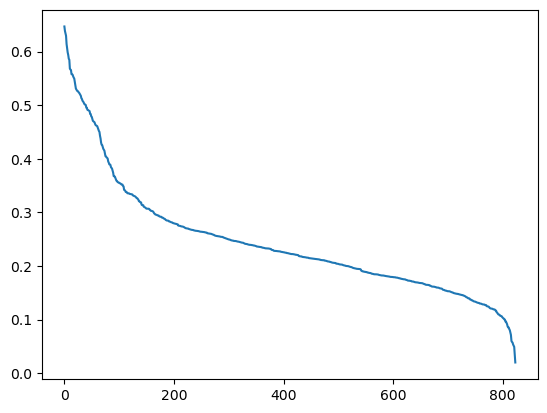

top1: 0.6467767743821009
top3: 0.6396126761349729
top5: 0.6324494850507533
top10: 0.6131675098870452
top50: 0.53843149982467


In [ ]:

import matplotlib.pyplot as plt
sorted_score_list = sorted(score_list, reverse=True)
plt.plot(sorted_score_list)
plt.show()

print("top1:", np.mean(sorted_score_list[:1]))
print("top3:", np.mean(sorted_score_list[:3]))
print("top5:", np.mean(sorted_score_list[:5]))
print("top10:", np.mean(sorted_score_list[:10]))
print("top50:", np.mean(sorted_score_list[:50]))
